# Assignment 4 Part B

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive/Colab\ Notebooks/neural\ project\ new/

In [ ]:
# import functions
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os
import pickle
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2


# **Dataset Generation**

In [ ]:
train_objSize = 9800
test_objSize = 200
imSize = 75 # size of image
objSize = 5 #size of objects in image 
qSize = 11 #6 for one-hot vector of color, 2 for question type, 3 for question subtype
nQuestion = 10 # Answer : [yes, no, rectangle, circle, r, g, b, o, k, y]
datadir = './data' # directory to store training data
colors = [(0,0,255),(0,255,0),(255,0,0),(0,156,255),(128,128,128),(0,255,255)]#r,g,b,o,k,y

try:
    os.makedirs(datadir)
except:
    print('Data directory already exists.')
    
def createCenter(objects):
    while True:
        pas = True
        center = np.random.randint(objSize, imSize - objSize, 2)        
        if len(objects) > 0:# if an object is already present, then find center that is 2X away for all old centers
            for name,c,shape in objects:
                if ((center - c) ** 2).sum() < ((objSize * 2) ** 2):
                    pas = False
        if pas:# if no old object is present, then no need to check anything
            return center

def putObjs():# function create 1 image and list of location,color,shape of 6 objects
    objects = []
    img = np.ones((imSize,imSize,3)) * 255 #plain white BG image
    for color_id,color in enumerate(colors): # put object of every color  
        center = createCenter(objects)
        # take 50% of objects as circles and 50% as rectangles
        if random.random()<0.5:
            start = (center[0]-objSize, center[1]-objSize)#xmin,ymin
            end = (center[0]+objSize, center[1]+objSize)#xmax,ymax
            cv2.rectangle(img, start, end, color, -1)
            objects.append((color_id,center,'r'))
        else:
            center_ = (center[0], center[1])
            cv2.circle(img, center_, objSize, color, -1)
            objects.append((color_id,center,'c'))
    return objects,img
  
def genOneVQA():# function will create 20 QA for 1 image
    objects,img = putObjs()

    rel_questions = []
    norel_questions = []
    rel_answers = []
    norel_answers = []
    
    # 10 Non-relational questions
    for idx in range(nQuestion):
        question = np.zeros((qSize))
        color = random.randint(0,5)
        question[color] = 1
        question[6] = 1
        subtype = random.randint(0,2)
        question[subtype+8] = 1
        norel_questions.append(question)
        if subtype == 0:
            """query shape->rectangle/circle"""
            if objects[color][2] == 'r':
                answer = 2
            else:
                answer = 3

        elif subtype == 1:
            """query horizontal position->yes/no"""
            if objects[color][1][0] < imSize / 2:
                answer = 0
            else:
                answer = 1

        elif subtype == 2:
            """query vertical position->yes/no"""
            if objects[color][1][1] < imSize / 2:
                answer = 0
            else:
                answer = 1
        norel_answers.append(answer)
    
    # 10 Relational questions
    for idx in range(nQuestion):
        question = np.zeros((qSize))
        color = random.randint(0,5)
        question[color] = 1
        question[7] = 1
        subtype = random.randint(0,2)
        question[subtype+8] = 1
        rel_questions.append(question)

        if subtype == 0:
            """closest-to->rectangle/circle"""
            my_obj = objects[color][1]
            dist_list = [((my_obj - obj[1]) ** 2).sum() for obj in objects]
            dist_list[dist_list.index(0)] = 999
            closest = dist_list.index(min(dist_list))
            if objects[closest][2] == 'r':
                answer = 2
            else:
                answer = 3
                
        elif subtype == 1:
            """furthest-from->rectangle/circle"""
            my_obj = objects[color][1]
            dist_list = [((my_obj - obj[1]) ** 2).sum() for obj in objects]
            furthest = dist_list.index(max(dist_list))
            if objects[furthest][2] == 'r':
                answer = 2
            else:
                answer = 3

        elif subtype == 2:
            """count->1~6"""
            my_obj = objects[color][2]
            count = -1
            for obj in objects:
                if obj[2] == my_obj:
                    count +=1 
            answer = count+4

        rel_answers.append(answer)

    relations = (rel_questions, rel_answers)
    norelations = (norel_questions, norel_answers)
    
    img = img/255. #normalize image
    dataset = (img, relations, norelations)
    return dataset


print('Building train and test datasets.')
test_datasets = [genOneVQA() for _ in range(test_size)]
train_datasets = [genOneVQA() for _ in range(train_size)]

  
filename = os.path.join(datadir,'sort-of-clevr.pickle')
with  open(filename, 'wb') as f:
    pickle.dump((train_datasets, test_datasets), f)
print('Dataset saved.')

Building train and test datasets.
Dataset saved.


In [ ]:
# !rm -rf data

# **Standard Functions**

In [ ]:
def tensor_data(data, i):
    img = torch.from_numpy(np.asarray(data[0][bs*i:bs*(i+1)]))
    qst = torch.from_numpy(np.asarray(data[1][bs*i:bs*(i+1)]))
    ans = torch.from_numpy(np.asarray(data[2][bs*i:bs*(i+1)]))

    input_img.data.resize_(img.size()).copy_(img)
    input_qst.data.resize_(qst.size()).copy_(qst)
    label.data.resize_(ans.size()).copy_(ans)


def cvt_data_axis(data):
    img = [e[0] for e in data]
    qst = [e[1] for e in data]
    ans = [e[2] for e in data]
    return (img,qst,ans)

    
def train(epoch, rel, norel):
    model.train()    
    random.shuffle(rel)
    random.shuffle(norel)

    rel = cvt_data_axis(rel)
    norel = cvt_data_axis(norel)

    for batch_idx in range(len(rel[0]) // bs):
        tensor_data(rel, batch_idx)
        accuracy_rel = model.train_(input_img, input_qst, label)

        tensor_data(norel, batch_idx)
        accuracy_norel = model.train_(input_img, input_qst, label)

        if batch_idx % args.log_interval == 0:
            print('Train Epoch '+ str(epoch) +' : Relations accuracy: ' + str(accuracy_rel.numpy())+'% : Non Relations accuracy: ' + str(accuracy_norel.numpy())+'%') 

def test(testFlag, rel, norel):
    model.eval()
    
    rel = cvt_data_axis(rel)
    norel = cvt_data_axis(norel)

    accuracy_rels = []
    accuracy_norels = []
    for batch_idx in range(len(rel[0]) // bs):
        tensor_data(rel, batch_idx)
        accuracy_rels.append(model.test_(input_img, input_qst, label)[1])

        tensor_data(norel, batch_idx)
        accuracy_norels.append(model.test_(input_img, input_qst, label)[1])

    accuracy_rel = sum(accuracy_rels) / len(accuracy_rels)
    accuracy_norel = sum(accuracy_norels) / len(accuracy_norels)
    print('\n '+ testFlag + ' : Relations accuracy: ' + str(accuracy_rel.numpy())+'% : Non Relations accuracy: ' + str(accuracy_norel.numpy())+'%') 



# **RN Model**

In [ ]:
# function for finding coordinates of visual words
def findCoords(i):
    if i>=0 and i<=4:
        tmp=[0,i]
    elif i>=5 and i<=9:
        tmp=[1,i%5]
    elif i>=10 and i<=14:
        tmp=[2,i%5]
    elif i>=15 and i<=19:
        tmp=[3,i%5]
    elif i>=20 and i<=24:
        tmp=[4,i%5]
    return list((np.array(tmp)/2)-1)

# cnn model  
class ConvInputModel(nn.Module):
    def __init__(self):
        super(ConvInputModel, self).__init__()        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)#input channel,output channel,kernel size
        self.batchNorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.batchNorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.batchNorm4 = nn.BatchNorm2d(256)
        
    def forward(self, in_img):
        x = self.conv1(in_img)
        x = F.relu(x)
        x = self.batchNorm1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batchNorm2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.batchNorm3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.batchNorm4(x)
        return x

# f_phi model  
class FCOutputModel(nn.Module):
    def __init__(self):
        super(FCOutputModel, self).__init__()
#         self.fc = nn.Linear(2000, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)

    def forward(self, x):
#         x = self.fc(x)
#         x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# base model
class BasicModel(nn.Module):
    def __init__(self, args, name):
        super(BasicModel, self).__init__()
        self.name=name

    def train_(self, input_img, input_qst, label): #model.train() is predefined, so i created train_
        self.optimizer.zero_grad()
        output = self(input_img, input_qst)
        loss = F.nll_loss(output, label)
        loss.backward()
        self.optimizer.step()
        pred = output.data.max(1)[1]
        correct = pred.eq(label.data).cpu().sum()
        accuracy = correct * 100. / len(label)
        return accuracy
        
    def test_(self, input_img, input_qst, label):
        output = self(input_img, input_qst)
        pred = output.data.max(1)[1]
        correct = pred.eq(label.data).cpu().sum()
        accuracy = correct * 100. / len(label)
        return pred,accuracy

    def save_model(self, epoch):
        torch.save(self.state_dict(), 'model/epoch_{}_{:02d}.pth'.format(self.name, epoch))


# RN model        
class RN(BasicModel):
    def __init__(self, args):
        super(RN, self).__init__(args, 'RN')
        
        self.conv = ConvInputModel()
        
        # g_theta
        ##(number of filters per object+coordinate of object)*2+question vector
        self.g_fc1 = nn.Linear((256+2)*2+11, 2000)
        self.g_fc2 = nn.Linear(2000, 2000)
        self.g_fc3 = nn.Linear(2000, 2000)
        self.g_fc4 = nn.Linear(2000, 2000)
        
        self.coordinates = torch.FloatTensor(args.batch_size, 25, 2)
        if args.cuda:
            self.coordinates = self.coordinates.cuda()
        self.coordinates = Variable(self.coordinates)
        np_coordinates = np.zeros((args.batch_size, 25, 2))
        for i in range(25):
            np_coordinates[:,i,:] = np.array( findCoords(i) )
        self.coordinates.data.copy_(torch.from_numpy(np_coordinates))

        # f_phi
        self.f_fc1 = nn.Linear(2000, 1000)
        self.fcout = FCOutputModel()
        
        # optimiser
        self.optimizer = optim.Adam(self.parameters(), lr=args.lr)


    def forward(self, img, q):
        x = self.conv(img) ## x = (bs x 256 x 5 x 5)        
        
        bs = x.size()[0]
        c = x.size()[1]
        d = x.size()[2]
        x = x.view(bs,c,d*d).permute(0,2,1)#(bs x 25 x 256)
        
        # add coordinates to all the visual words
        x = torch.cat([x, self.coordinates],2)#(bs x 25 x 258)
        
        # repeat question as many times as the no. of objects
        q = torch.unsqueeze(q, 1)
        q = q.repeat(1,25,1)
        q = torch.unsqueeze(q, 2)
        
        # combine all object pairs with questions
        o1 = torch.unsqueeze(x,1) # (bsx1x25x258)
        o1 = o1.repeat(1,25,1,1) # (bsx25x25x258)
        o2 = torch.unsqueeze(x,2) # (bsx25x1x258)
        o2 = torch.cat([o2,q],3)# (bsx25x1x(258+11))
        o2 = o2.repeat(1,1,25,1) # (bsx25x25x(258+11))
        
        # concatenate all together
        x = torch.cat([o1,o2],3) # (bsx25x25x(258+258+11))
        
        # reshape for passing through network
        x = x.view(bs*d*d*d*d,527) #527=258X2+11
        x = F.relu(self.g_fc1(x))
        x = F.relu(self.g_fc2(x))
        x = F.relu(self.g_fc3(x))
        x = F.relu(self.g_fc4(x))
        
        # sum: polling to introduce order invariance amoung objects
        x = x.view(bs,d*d*d*d,2000)
        x = x.sum(1).squeeze()
        
        # f_phi
        x = F.relu(self.f_fc1(x))
        
        return self.fcout(x)


# **Training**

In [ ]:
# Load data
def load_data():
    dirs = './data'
    filename = os.path.join(dirs,'sort-of-clevr.pickle')
    with open(filename, 'rb') as f:
      train_datasets, test_datasets = pickle.load(f)
    rel_tmp = []
    rel_test = []
    norel_tmp = []
    norel_test = []
    
    for img, relations, norelations in train_datasets:
        img = np.swapaxes(img,0,2)
        for qst,ans in zip(relations[0], relations[1]):
            rel_tmp.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_tmp.append((img,qst,ans))

    for img, relations, norelations in test_datasets:
        img = np.swapaxes(img,0,2)
        for qst,ans in zip(relations[0], relations[1]):
            rel_test.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_test.append((img,qst,ans))
    
    #use 10% of training data as validation
    rel_train, rel_val = train_test_split(rel_tmp, test_size=0.10, random_state=42)
    norel_train, norel_val = train_test_split(norel_tmp, test_size=0.10, random_state=42)
    
    return (rel_train, rel_test, rel_val, norel_val, norel_train, norel_test)
    

rel_train, rel_test, rel_val, norel_val, norel_train, norel_test = load_data()
print('Data loaded.')    

Data loaded.


In [ ]:
# create model object
from argparse import Namespace
# resumeFlag=None
resumeFlag='final_epoch_RN_03.pth'
bs=64
mydict={'batch_size':bs,'cuda':True,'epochs':20,'log_interval':10,'lr':0.0001,'model':'RN','no_cuda':False,'resume':resumeFlag,'seed':1}
args = Namespace(**mydict)
model=RN(args)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
model

In [ ]:
# Training the model and validation in batches
model_dirs = './model'
bs = args.batch_size
input_img = torch.FloatTensor(bs, 3, 75, 75)
input_qst = torch.FloatTensor(bs, 11)
label = torch.LongTensor(bs)

if args.cuda:
    model.cuda()
    input_img = input_img.cuda()
    input_qst = input_qst.cuda()
    label = label.cuda()

input_img = Variable(input_img)
input_qst = Variable(input_qst)
label = Variable(label)

try:
    os.makedirs(model_dirs)
except:
    print('Model directory already exists.')

if args.resume:
    filename = os.path.join(model_dirs, args.resume)
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint)
        print('Checkpoint '+filename+' loaded.')

for epoch in range(1, args.epochs + 1):
    train(epoch, rel_train, norel_train)
    test('Validation', rel_val, norel_val)
    model.save_model(epoch)

# **Testing**

In [ ]:
from argparse import Namespace
model_dirs = './model'

# resumeFlag=None
resumeFlag='final_epoch_RN_03.pth'#has 92% test acc.
bs=64
# bs=80
mydict={'batch_size':bs,'cuda':True,'epochs':20,'log_interval':10,'lr':0.0001,'model':'RN','no_cuda':False,'resume':resumeFlag,'seed':1}
args = Namespace(**mydict)
model=RN(args)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

if args.resume:
    filename = os.path.join(model_dirs, args.resume)
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint)
        print('Checkpoint '+filename+' loaded.')
        
test('Test', rel_test, norel_test)

Checkpoint ./model/final_epoch_RN_03.pth loaded.

 Test : Relations accuracy: 92% : Non Relations accuracy: 99%


# **Result Visualization**

In [ ]:
#Load the data
dirs = './data'
filename = os.path.join(dirs,'sort-of-clevr.pickle')
with open(filename, 'rb') as f:
  train_datasets, test_datasets = pickle.load(f)
rel_train = []
rel_test = []
norel_train = []
norel_test = []

for img, relations, norelations in train_datasets:
    img = np.swapaxes(img,0,2)
    for qst,ans in zip(relations[0], relations[1]):
        rel_train.append((img,qst,ans))
    for qst,ans in zip(norelations[0], norelations[1]):
        norel_train.append((img,qst,ans))

for img, relations, norelations in test_datasets:
    img = np.swapaxes(img,0,2)
    for qst,ans in zip(relations[0], relations[1]):
        rel_test.append((img,qst,ans))
    for qst,ans in zip(norelations[0], norelations[1]):
        norel_test.append((img,qst,ans))

In [ ]:
from argparse import Namespace
resumeFlag='final_epoch_RN_03.pth'#has 92% test acc.
mydict={'batch_size':64,'cuda':True,'epochs':20,'log_interval':10,'lr':0.0001,'model':'RN','no_cuda':False,'resume':resumeFlag,'seed':1}
args = Namespace(**mydict)
model=RN(args)
model.load_state_dict(torch.load('model/final_epoch_RN_03.pth'))
model.eval();

In [ ]:
# function plotting and visualizing results
colors = ['red ', 'green ', 'blue ', 'orange ', 'gray ', 'yellow ']
answer_sheet = ['yes', 'no', 'rectangle', 'circle', '1', '2', '3', '4', '5', '6']

def plot_RN_result(idx):
  img2 = np.swapaxes(input_img[idx].cpu().detach().numpy(),0,2)
  plt.imshow(np.dstack((img2[:,:,2],img2[:,:,1],img2[:,:,0])));
  plt.grid(False)
  question=input_qst[idx]
  if question[6] == 1:
      query = 'Q: The object with color '
      query += colors[question.tolist()[0:6].index(1)]+', '  
      if question[8] == 1:
          query += 'has what shape?'
      if question[9] == 1:
          query += 'is towards the left?'
      if question[10] == 1:
          query += 'is towards the top?'
  if question[7] == 1:
      query = 'Q: For the object with color '
      query += colors[question.tolist()[0:6].index(1)]+', '  
      if question[8] == 1:
          query += 'the shape of the closest object is?'
      if question[9] == 1:
          query += 'the shape of the furthest object is??'
      if question[10] == 1:
          query += 'the number of objects having the same shape is?'
  print(query)    
  print('A: ',answer_sheet[accuracy_rels[0][idx]],' (Predicted)')
  print('A:' ,answer_sheet[label[idx]],' (Desired)')


 ## *Relational*

In [ ]:
epoch=0
bs=64
input_img = torch.FloatTensor(bs, 3, 75, 75)
input_qst = torch.FloatTensor(bs, 11)
label = torch.LongTensor(bs)

model.cuda()
input_img = input_img.cuda()
input_qst = input_qst.cuda()
label = label.cuda()

accuracy_rels = []
rel_test2 = cvt_data_axis(rel_test)
batch_idx=1
# for batch_idx in range(len(rel_test2[0]) // bs):
tensor_data(rel_test2, batch_idx);
accuracy_rels.append(model.test_(input_img, input_qst, label)[0]);


Q: For the object with color green , the shape of the closest object is?
A:  circle  (Predicted)
A: circle  (Desired)


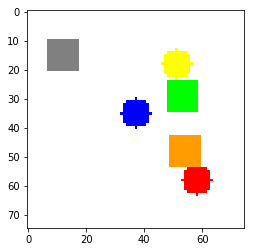

In [ ]:
idx=4#index of img,question,answer
plot_RN_result(idx)

Q: For the object with color blue , the number of objects having the same shape is?
A:  4  (Predicted)
A: 4  (Desired)


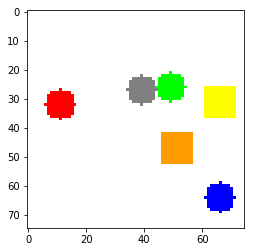

In [ ]:
idx=30#index of img,question,answer
plot_RN_result(idx)

Q: For the object with color green , the shape of the furthest object is??
A:  rectangle  (Predicted)
A: rectangle  (Desired)


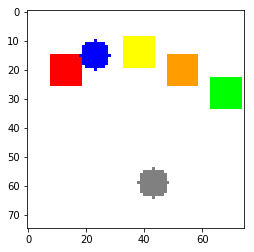

In [ ]:
idx=45#index of img,question,answer
plot_RN_result(idx)

Q: For the object with color green , the shape of the furthest object is??
A:  circle  (Predicted)
A: circle  (Desired)


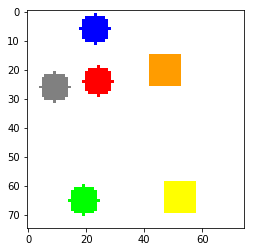

In [ ]:
idx=63#index of img,question,answer
plot_RN_result(idx) #XXXXXXX

Q: For the object with color orange , the shape of the furthest object is??
A:  circle  (Predicted)
A: circle  (Desired)


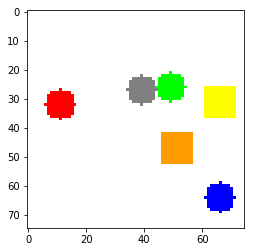

In [ ]:
idx=34#index of img,question,answer
plot_RN_result(idx)

 ## *Non-Relational*

In [ ]:
epoch=0
bs=64
input_img = torch.FloatTensor(bs, 3, 75, 75)
input_qst = torch.FloatTensor(bs, 11)
label = torch.LongTensor(bs)

model.cuda()
input_img = input_img.cuda()
input_qst = input_qst.cuda()
label = label.cuda()

accuracy_rels = []
norel_test2 = cvt_data_axis(norel_test)
batch_idx=1
# for batch_idx in range(len(rel_test2[0]) // bs):
tensor_data(norel_test2, batch_idx);
accuracy_rels.append(model.test_(input_img, input_qst, label)[0]);


Q: The object with color yellow , is towards the top?
A:  yes  (Predicted)
A: yes  (Desired)


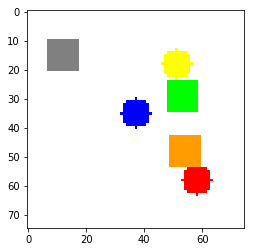

In [ ]:
idx=4#index of img,question,answer
plot_RN_result(idx)

Q: The object with color gray , is towards the left?
A:  no  (Predicted)
A: no  (Desired)


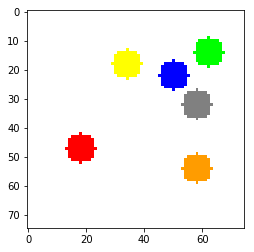

In [ ]:
idx=20#index of img,question,answer
plot_RN_result(idx)

Q: The object with color green , has what shape?
A:  rectangle  (Predicted)
A: rectangle  (Desired)


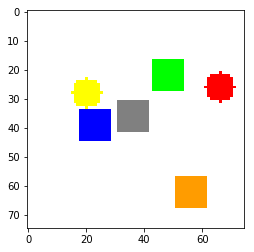

In [ ]:
idx=52#index of img,question,answer
plot_RN_result(idx)

Q: The object with color gray , has what shape?
A:  circle  (Predicted)
A: circle  (Desired)


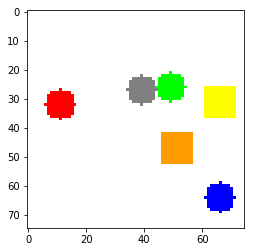

In [ ]:
idx=33#index of img,question,answer
plot_RN_result(idx)

Q: The object with color red , has what shape?
A:  rectangle  (Predicted)
A: rectangle  (Desired)


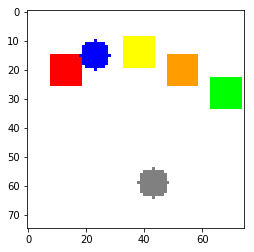

In [ ]:
idx=40#index of img,question,answer
plot_RN_result(idx)